In [1]:
import pandas as pd 
import numpy as np
from math import sqrt
from copy import deepcopy
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#For e-autoMFIS, we import all of them.
from eautoMFIS_V2 import autoMFIS
from fuzzyfication import Fuzzification
from preprocessing import Preprocess
from utils import *

from pymoo.core.problem import  ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization


import warnings
warnings.filterwarnings("ignore")

In [2]:
#Rule Object structure
class rule_object():
    def __init__(self,complete_rules,prem_terms,rules,wd_,index):
        self.complete_rules = complete_rules
        self.prem_terms = prem_terms
        self.rules = rules
        self.index = index
        self.wd_ = wd_

In [3]:
#Basic informations 

num_predictors = 5
num_input = 14
lag = 24
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False



#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

In [4]:
dataset = pd.read_csv('exchange_rate.txt',header=None)

In [5]:
MA = 5
MA_values = np.zeros((dataset.shape[0]-MA,dataset.shape[1]))
for i in range(dataset.shape[1]):
    a = dataset[i].rolling(window=MA).mean().values
    MA_values[:,i] = a[5:]

In [6]:
MA_dataset = pd.DataFrame(MA_values)

In [7]:
#We are going to split between training, validation and test set.
#Training set: 2 months of data (168*60) + lag
#Validation set: 168 steps (1 week)
#Test set: 168 steps (1 week)

h_test = int(0.1993*dataset.shape[0])
h_val = 24
#h_train = dataset.shape[0] - h_val - h_test - lag - 2
h_train = 24*30

a = MA_dataset.shape[0]
all_data = MA_dataset[a - h_train - lag - 1 - h_val - h_test:]
training_data = MA_dataset[a - h_train - lag - 1 - h_val - h_test:a-h_test]
test_data = MA_dataset[a - h_test:a]

In [8]:
training_values = training_data.values

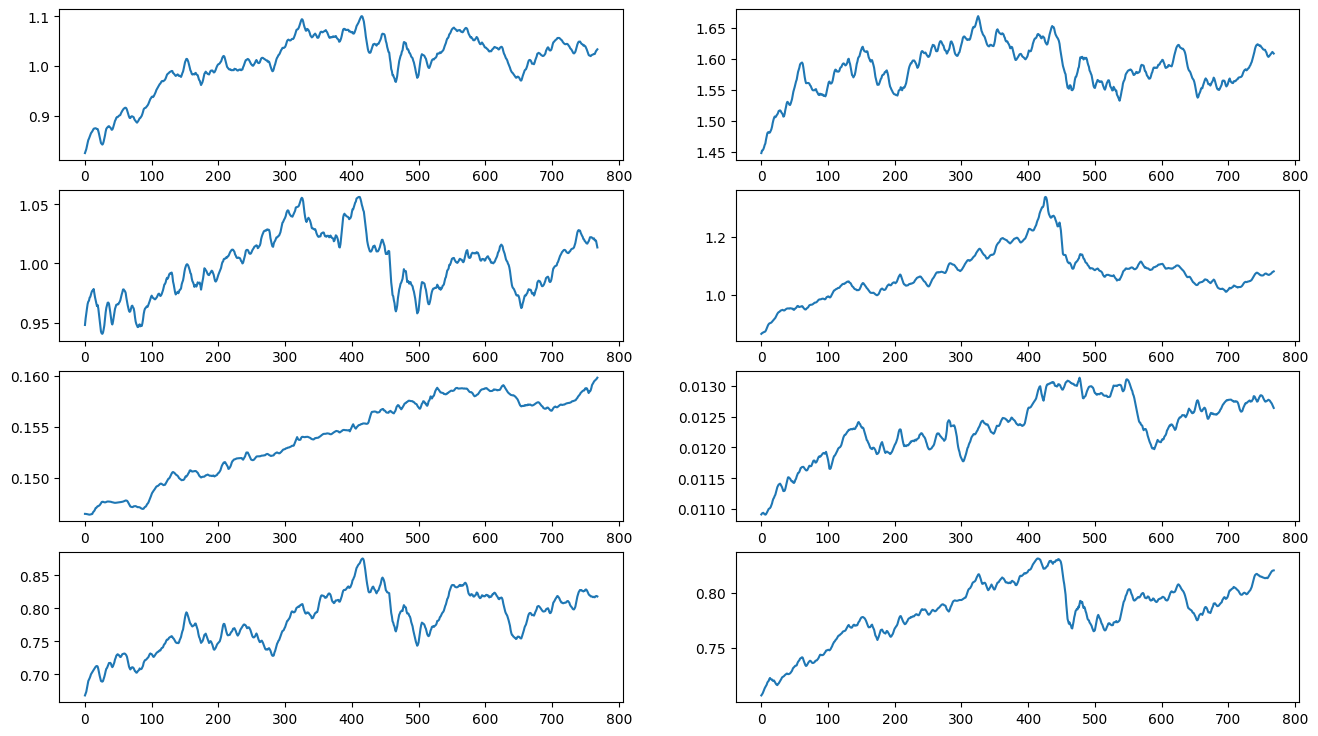

In [9]:
plt.figure(figsize=(16,9))
for n in range(8):
    plt.subplot(4,2,n+1)
    plt.plot(training_values[:,n])

In [10]:
#data = data1[:,[0, 61, 147, 241]]
#data_ = training_values[:,[0,6]]
#data_ = training_values[:,[0,2,6,7]]
data_ = training_values
#data_ = training_values[:,[0, 61, 147, 241]]

In [11]:
data_.shape

(769, 8)

In [12]:
#bin_values = 12; #Representação da binarização do tempo.
num_series = data_.shape[1]  #Numero de series do problema, extraído dos dados

max_rulesize = 7 #Max numbers of premises rules.
min_activation = 0.8     #Minimum activation

form_method = 'nmean'
split_method = 'FCD'
solve_method = 'mqr'
#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_cluster'
num_groups = 3

defuzz_method = 'height'

ensemble_rules = None

total_number = data_.shape[1]*lag


filepath = 'results V2'



# Data for the Actual Model

In [13]:

#Normalize data 
scaler = StandardScaler()
#scaler = MinMaxScaler()
# preprocess_data = Preprocess(data_,h_prev=h_val,num_series=num_series, lag=lag)
preprocess_data = Preprocess(data_, lag, h_prev=h_val,num_series=num_series, target_position = -1)

#For training set
#training_set_orig, val_set_orig = preprocess_data.diff_series()

# training_val_set_orig, test_set_orig = preprocess_data.split_data()

training_set_orig, val_set_orig, trends = preprocess_data.detrend_series()

diff_data = np.concatenate((training_set_orig, val_set_orig))

norm_data = scaler.fit_transform(diff_data)
training_set = scaler.transform(training_set_orig)
val_set = scaler.transform(val_set_orig)

training_set[abs(training_set) > 3] = 0

yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)
#For all set. This will be useful for initial values of prediction
all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = norm_data, lag = lag)

In [18]:
print(f'training_set_orig: {training_set_orig.shape}')
print(f'val_set_orig: {val_set_orig.shape}')
print(f'trends: {trends.shape}')
print(f'diff_data: {diff_data.shape}')
print(f'yt: {yt.shape}')
print(f'yp: {yp.shape}')
print(f'yp_lagged: {yp_lagged.shape}')
print(f'all_yt: {all_yt.shape}')
print(f'all_yp: {all_yp.shape}')
print(f'all_lagged: {all_lagged.shape}')


training_set_orig: (745, 8)
val_set_orig: (24, 8)
trends: (769, 8)
diff_data: (769, 8)
yt: (720, 8)
yp: (720, 8)
yp_lagged: (720, 192)
all_yt: (744, 8)
all_yp: (744, 8)
all_lagged: (744, 192)


In [15]:
process_all = Preprocess(all_data.values, lag=lag, h_prev = h_test, num_series=num_series, target_position=-1)
train_val_org, test_set_orig, a_trends = process_all.detrend_series()
detrend_data = np.concatenate((train_val_org, test_set_orig))

norm_data = scaler.fit_transform(detrend_data)
training_set = scaler.transform(train_val_org)
#val_set = scaler.transform(val_set_orig)

test_set_norm = scaler.transform(test_set_orig)
#all_data_norm = scaler.transform(all_data)

test_all_yt, test_all_yp, test_all_lagged = preprocess_data.delay_input(in_sample = norm_data, lag = lag)

In [19]:
print(f'train_val_org: {train_val_org.shape}')
print(f'test_set_orig: {test_set_orig.shape}')
print(f'a_trends: {a_trends.shape}')
print(f'detrend_data: {detrend_data.shape}')
print(f'test_all_yt: {test_all_yt.shape}')
print(f'test_all_yp: {test_all_yp.shape}')
print(f'test_all_lagged: {test_all_lagged.shape}')

train_val_org: (769, 8)
test_set_orig: (1512, 8)
a_trends: (2281, 8)
detrend_data: (2281, 8)
test_all_yt: (2256, 8)
test_all_yp: (2256, 8)
test_all_lagged: (2256, 192)


# Data for the Hyperparameter tuning

In [33]:
ev_scaler = StandardScaler()
#scaler = MinMaxScaler()
# preprocess_data = Preprocess(data_,h_prev=h_val,num_series=num_series, lag=lag)
#For training set
#training_set_orig, val_set_orig = preprocess_data.diff_series()

ev_training_val_set_orig, ev_test_set_orig = preprocess_data.split_data()

ev_training_set_orig, ev_val_set_orig, ev_trends = preprocess_data.detrend_series(ev_training_val_set_orig)

ev_diff_data = np.concatenate((ev_training_set_orig, ev_val_set_orig))

ev_norm_data = ev_scaler.fit_transform(ev_diff_data)
ev_training_set = ev_scaler.transform(ev_training_set_orig)
ev_val_set = ev_scaler.transform(ev_val_set_orig)

ev_training_set[abs(ev_training_set) > 3] = 0

ev_yt, ev_yp, ev_yp_lagged = preprocess_data.delay_input(in_sample = ev_training_set, lag = lag)
#For all set. This will be useful for initial values of prediction
ev_all_yt, ev_all_yp, ev_all_lagged = preprocess_data.delay_input(in_sample = ev_norm_data, lag = lag)

In [20]:
print(f'ev_training_val_set_orig: {ev_training_val_set_orig.shape}')
print(f'ev_test_set_orig: {ev_test_set_orig.shape}')
print(f'ev_training_set_orig: {ev_training_set_orig.shape}')
print(f'ev_val_set_orig: {ev_val_set_orig.shape}')
print(f'ev_trends: {trends.shape}')
print(f'ev_diff_data: {ev_diff_data.shape}')
print(f'ev_yt: {ev_yt.shape}')
print(f'ev_yp: {ev_yp.shape}')
print(f'ev_yp_lagged: {ev_yp_lagged.shape}')
print(f'ev_all_yt: {ev_all_yt.shape}')
print(f'ev_all_yp: {ev_all_yp.shape}')
print(f'ev_all_lagged: {all_lagged.shape}')

NameError: name 'ev_training_val_set_orig' is not defined

In [35]:
ev_all_training_val_orig, ev_all_test_set_orig = process_all.split_data()
ev_all_train_org, ev_all_val_set_orig, ev_all_trends = process_all.detrend_series(ev_all_training_val_orig)
ev_all_detrend_data = np.concatenate((ev_all_train_org, ev_all_val_set_orig))

ev_all_norm_data = scaler.fit_transform(ev_all_detrend_data)
ev_all_training_set = scaler.transform(ev_all_train_org)
#val_set = scaler.transform(val_set_orig)

ev_all_test_set_norm = scaler.transform(ev_all_val_set_orig)
#all_data_norm = scaler.transform(all_data)

_, _, ev_test_all_lagged = preprocess_data.delay_input(in_sample = ev_all_norm_data, lag = lag)

In [36]:
print(f'ev_all_training_val_orig: {ev_all_training_val_orig.shape}')
print(f'ev_all_test_set_orig: {ev_all_test_set_orig.shape}')
print(f'ev_all_train_org: {ev_all_train_org.shape}')
print(f'ev_all_val_set_orig: {ev_all_val_set_orig.shape}')
print(f'ev_all_trends: {ev_all_trends.shape}')
print(f'ev_all_detrend_data: {ev_all_detrend_data.shape}')
print(f'ev_test_all_lagged: {ev_test_all_lagged.shape}')

(744, 192)

In [37]:
def fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp, yt, yp_lagged, lag):
    ###############Fuzzificacao

    Fuzzyfy = Fuzzification(fuzzy_method)

    #Lembrete: 
    #axis 0 - Registros da série
    #axis 1 - Valor de pertinência ao conjunto Fuzzy
    #axis 2 - Numero de séries

    first_time = True
    # print(f'Serie fuzzification')
    for n in range(num_series):
        _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
        mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
        mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
        if first_time:
            mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
            mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
            mf_params_ = np.ndarray([mf_params.shape[0],num_series])
            first_time = False
        mX_[:,:,n] = mX
        mY_[:,:,n] = mY
        mf_params_[:,n] = mf_params.ravel()
        #print(mf_params)
        #print(mX.shape)

    # print('Creating for lag values')
    mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
    for i in range(num_series):
        # print(f'Serie {i}')
        mf_params = mf_params_[:,i]
        for j in range(lag):
            mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
            mX_lagged_[:,:,i*lag+j] = mX
            #print(i*lag+j)


    #mX_lagged_[:,:,not_select_subsample] = 0
 
    #print(mX_lagged_[:,:,not_select_subsample])
    ############## Formulacao
    if not_used_lag:
        new_mX, lags_used = remove_lags (mX_lagged_,lag_notused,num_series,lag)
    else:
        new_mX = mX_lagged_

    return Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_


In [38]:
n_threads = 1
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

In [39]:
class ExchangeRateProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
            
            vars = {
                # "lag": Integer(bounds=(16,24)),
                # "n_inputs": Integer(bounds=(10,20)),
                "max_rulesize": Integer(bounds=(5, 7)),
                "min_activation": Real(bounds=(0.5, 0.655)),
                # "form_method": Choice(options=["nmean", "freq", "mean"]),
                # "split_method": Choice(options=["FCD", "voting"]),
                # "solve_method": Choice(options=['mqr', 'None']),
                # "fuzzy_method": Choice(options=['mfdef_cluster', 'mfdef_triangle',  'mfdef_tukkey']),
                "num_groups": Choice(options=[3, 5, 7, 9]),
                # "defuzz_method": Choice(options=["height", "cog", "mom" ])
            }
            super().__init__(vars=vars, n_obj=3, **kwargs)

    def _evaluate(self, x,  out, *args, **kwargs):
        # Define o número máximo de threads a serem usadas pelo Python
        
        print(x)
        # lag = x["lag"]
        # num_input = x["n_inputs"]
        max_rulesize = x["max_rulesize"] #Max numbers of premises rules.
        min_activation = x["min_activation"] #Minimum activation
        # form_method = x["form_method"]
        # split_method = x["split_method"]
        # solve_method = x["solve_method"]
        # fuzzy_method = x["fuzzy_method"]
        num_groups = x["num_groups"]
        # defuzz_method = x["defuzz_method"]

        initial_values = ev_all_lagged[ev_yp_lagged.shape[0],:].reshape(1,-1)
        in_sample = deepcopy(ev_training_set)
        out_sample = deepcopy(ev_val_set)
        # best_list_rules = [rule_object(None,None,None,None,i) for i in range(in_sample.shape[1])]
        # best_t_mX_lagged_list = [None]*in_sample.shape[1]
        # best_agg_training_list = [None]*in_sample.shape[1]

        for target in range(in_sample.shape[1]):
            min_error = 300.0
            
            bres = min_error

            linear_auto_corr = preprocess_data.linear_acf_weights(in_sample = in_sample)

            linear_cross_corr = preprocess_data.spearman_corr_weights(in_sample = in_sample, target_position=target)

            #Concatenate rules
            for i in range(num_predictors):
                try:
                    _, _, yp_lagged_ = preprocess_data.generate_subsamples(correlation_array=deepcopy(linear_cross_corr),
                                                                            autocorrelation_matrix=deepcopy(linear_auto_corr),
                                                                            num_inputs=num_input, 
                                                                            in_sample=in_sample, 
                                                                            yt = ev_yt, 
                                                                            yp = ev_yp, 
                                                                            yp_lagged = deepcopy(ev_yp_lagged))
                    
                    Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_external(fuzzy_method, num_series, ev_training_set, num_groups, ev_yp, ev_yt, deepcopy(yp_lagged_), lag)

                    model = autoMFIS(diff_series=diff_series,
                                     detrend_series=detrend_series,
                                     fuzzy_method=fuzzy_method,
                                     solve_method=solve_method,
                                     defuzz_method=defuzz_method, 
                                     num_groups = num_groups, 
                                     h_prev = out_sample.shape[0], 
                                     num_series = num_series, 
                                     max_rulesize = max_rulesize, 
                                     min_activation = min_activation, 
                                     lag = lag, 
                                     hide_values = False, 
                                     form_method = form_method, 
                                     split_method = split_method, 
                                     show=False)
                    
                    # not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
                    t_mX_lagged = deepcopy(mX_lagged_)
                    # t_mX_lagged[:,:,not_select_subsample] = 0

                    model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, t_mX_lagged)        

                    _, complete_rules, prem_terms, rules, agg_training, wd_ = model.train(
                                                                                            ev_all_norm_data, 
                                                                                            yt=ev_yt,
                                                                                            yp=ev_yp,
                                                                                            yp_lagged=ev_yp_lagged,
                                                                                            correlation_array=linear_cross_corr, 
                                                                                            autocorrelation_matrix=linear_auto_corr,
                                                                                            in_sample=in_sample,
                                                                                            out_sample=out_sample, 
                                                                                            lag_notused=[],
                                                                                            debug=True
                                                                                         )



                    #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
                    print(f'Predict on validation set - #{i}')
                    #Prediction of a single subset
                    #yt_totest, errors = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
                    predicted_values = np.zeros(test_data.values.shape)
                    init = in_sample.shape[0]
                    for k in range(0,h_test,24):

                        initial_values = ev_test_all_lagged[ev_yp_lagged.shape[0]+k,:].reshape(1,-1)
                        yt_totest, errors = model.predict(
                                                            initial_values, 
                                                            data=ev_norm_data, 
                                                            in_sample = ev_yt, 
                                                            out_sample=ev_val_set, 
                                                            agg_training=agg_training,
                                                            h_prev=24,
                                                            n_attempt=f'p_subsample_{i}',
                                                            wd_=wd_,
                                                            ensemble_antecedents=rules,
                                                            ensemble_rules=complete_rules, 
                                                            filepath=filepath, 
                                                            lim=min_error, 
                                                            fig_axis=[4,2],
                                                            ndata=MA_dataset,
                                                            show=False
                                                         )
                        
                        a = scaler.inverse_transform(yt_totest)
                        #print(k)
                        if (k+24 > predicted_values.shape[0]):
                            bb = predicted_values.shape[0] - k
                            b = a[-bb:,:] + ev_all_trends[init+k:init+k+bb,:]
                            predicted_values[k:k+bb,:] = b
                        else:
                            b = a + ev_all_trends[init+k:init+k+24,:]
                            predicted_values[k:k+24,:] = b
                    F = predicted_values
                    A = test_data.values     
                    num = sqrt(np.sum((F-A)**2))
                    den = sqrt(np.sum((A-np.mean(A))**2))
                    rrse = num/(den+0.0000001)
                    print(rrse)
                    #errors = predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged1,h_prev=out_sample.shape[0],not_used_lag=not_used_lag,n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])
                    #print(errors)
                    #print(complete_rules)
                    
                    if rrse < bres:
                        bres = rrse 
                        if ensemble_rules is None:
                            ensemble_rules = complete_rules
                            ensemble_prem_terms = prem_terms
                            ensemble_antecedents = rules
                            #print(ensemble_rules.shape)
                        else:
                            ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                            
                            ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                            ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                            #print(ensemble_rules.shape)
                            #print(ensemble_prem_terms.shape)
                        #print(ensemble_rules[:,0])
                    elif ensemble_rules is None and i == num_predictors - 1:
                        if target == 0:
                            ensemble_rules = complete_rules
                            ensemble_prem_terms = prem_terms
                            ensemble_antecedents = rules
                        else:
                            ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                            ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                            ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                            print('No rules match criteria. Using rules to fill the gap')

                except Exception as e:
                    print(e)
                    pass

                cnt = 0
                list_remove = []

                dict_val = {}

                for i in range(ensemble_prem_terms.shape[0]):
                    except_one = np.copy(ensemble_prem_terms)
                    v = except_one[i,:]
                    idx = np.argwhere(v > 0.5).ravel()
                    v = v[idx]
                    rest = np.delete(except_one, i, axis=0)
                    rest = rest[:,idx]
                    cpare = np.tile(v,(rest.shape[0],1))
                    m = np.minimum(rest,cpare) 
                    M = np.maximum(rest,cpare) + 10e-15
                    res = m/M
                    mean = np.mean(res,axis=1)
                    #plt.figure()
                    #plt.hist(mean)
                    
                    vv = np.argwhere(mean > 0.6).ravel()

                    if vv.shape[0] > 0:    
                        vv[vv > i] += 1
                        vv2 = np.append(vv,np.array([i]))

                        eval_v = ensemble_prem_terms[vv2][:,idx]

                        t = np.mean(eval_v,axis=1)

                        keep_val = vv2[np.argmax(t)]
                        vmax = np.max(t)
                        print(f'{keep_val} : {vmax}')
                        if keep_val not in list_remove:
                            dict_val[keep_val] = 1
                            list_remove.append(keep_val)
                        else:
                            dict_val[keep_val] = dict_val[keep_val] + 1

                        cnt += np.argwhere(mean > 0.6).shape[0]

                filtered_rules = deepcopy(ensemble_rules[list_remove,:])
                filtered_prems = deepcopy(ensemble_prem_terms[list_remove,:])
                filtered_antecedents = deepcopy(ensemble_antecedents[list_remove,:])
                
                model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
                filtered_wd_, filtered_agg_training = model.reweight_mf(mY_,filtered_rules,filtered_prems)

                filtered_predicted_values = np.zeros(test_data.values.shape)
                init = in_sample.shape[0]
                for k in range(0,h_test,24):
                    print(k)
                    initial_values = ev_test_all_lagged[ev_yp_lagged.shape[0]+k,:].reshape(1,-1)
                    yt_totest, _ = model.predict(initial_values, 
                                                data=ev_all_norm_data, 
                                                in_sample = ev_yt, 
                                                out_sample=ev_val_set, 
                                                agg_training=filtered_agg_training,
                                                h_prev=24,
                                                n_attempt=f'p_subsample_{i}',
                                                wd_=filtered_wd_,
                                                ensemble_antecedents=filtered_antecedents,
                                                ensemble_rules=filtered_rules, 
                                                filepath=filepath, 
                                                lim=min_error, 
                                                fig_axis=[4,2],
                                                ndata=MA_dataset,
                                                show=False)

                    a = scaler.inverse_transform(yt_totest)
                    b = a + ev_all_trends[init+k:init+k+24,:]
                    filtered_predicted_values[k:k+24,:] = b

                    F = filtered_predicted_values[:1510,:]
                    A = test_data.values[:1510,:]     
                    num = sqrt(np.sum((F-A)**2))
                    den = sqrt(np.sum((A-np.mean(A))**2))
                    filtered_errors = num/(den+0.0000001)

                    out["F"] = [filtered_errors, filtered_rules.shape[0], filtered_rules.shape[1]]

In [40]:
algorithm = NSGA2(pop_size=10,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

problem = ExchangeRateProblem(elementwise_runner=runner)

res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=False)

{'max_rulesize': 6, 'min_activation': 0.6038106357045394, 'num_groups': 5}
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Filter
Step 5 - Reweight
Step 6 - Defuzzification
Predict on validation set - #0
index 744 is out of bounds for axis 0 with size 744
{'max_rulesize': 6, 'min_activation': 0.5485573951245026, 'num_groups': 3}
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Filter
Step 5 - Reweight
Step 6 - Defuzzification
Predict on validation set - #0
index 744 is out of bounds for axis 0 with size 744
{'max_rulesize': 5, 'min_activation': 0.535584468128123, 'num_groups': 5}
Step 1 - Fuzzification
Step 2 - Formulation


In [19]:
#diff_data.shape
#diff_data = data_

In [20]:
#plt.plot(yt[:,2])
#plt.ylabel('Diff values')
#plt.xlabel('Timestamp (h)')

In [21]:
#plt.plot(norm_data[:,2])
#plt.ylabel('Diff values')
#plt.xlabel('Timestamp (h)')

In [22]:
#For all set. This will be useful for initial values of prediction
#all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = diff_data, lag = lag)

In [23]:
#plt.plot(yt[200:,1])

In [24]:
# assert ev_val_set.shape[0] == h_val
# assert ev_yp_lagged.shape[0] == h_train
# assert yt.shape[0] == h_train

In [25]:
#dataset.shape

In [26]:
# import seaborn as sns
# from copy import deepcopy
# from utils import *

# import itertools
# import json
# import os

# #For e-autoMFIS, we import all of them.
# from eautoMFIS_V2 import autoMFIS
# import numpy as np
# import scipy.io
# from reweight import Reweight
# from fuzzyfication import Fuzzification
# from defuzzification import Defuzzification
# import matplotlib.pyplot as plt
# from predict import predict, predict_pattern



# def convert_object_to_float(data,datanames):
    
#     for name in datanames:
#         dname = data[name].values.astype('str')
#         dname = [new_value.replace(',','.') for new_value in dname]
#         data[name] = dname
#         data[name] = data[name].astype(float)
#     return data

# ##Assertion for ensemble rules
# #Somehow, when appending rules, ensemble_rules[:,1] has a erroneous form. This part seems to normalize it.

# #This module correct this error. Also, we are going to use some assertion to check if rules contains the same antecedents.
# def correct_bug(ensemble_rules,max_rulesize=0):
#     correct_rule = []
#     d_stacked_rules = []
#     new_ensemble_rules = np.zeros(shape=ensemble_rules.shape, dtype=object)


#     for  n_times in range(ensemble_rules.shape[1]):
#         t_rules = ensemble_rules[:,n_times]
#         correct_rule = []
#         d_stacked_rules = []
#         k = 0
#         for rule in t_rules:
#             #print(rule)
#             #print(len(rule))
#             #Check if there's a rule bigger than max_rulesize + 1 (#antecedents + #consequent)
#             if len(rule) > max_rulesize + 1:
#                 #print(rule)
#                 for i in rule:
#                     #k += 1
#                     if isinstance(i,tuple):
#                         #print(i)
#                         correct_rule.append(i)
#                     else:
#                         if len(correct_rule) == 0:
#                             #print(i)
#                             pass
#                             #d_stacked_rules.append(i)
#                         else:
#                             #print(correct_rule)
#                             new_ensemble_rules[k,n_times] = correct_rule
#                             k += 1
#                             #d_stacked_rules.append(correct_rule)
#                             correct_rule = []
#                             #d_stacked_rules.append(i)
#             else:
#                 new_ensemble_rules[k,n_times] = rule
#                 k += 1
#                 #d_stacked_rules.append(rule)
            
#         #new_ensemble_rules[:,i] = np.array(d_stacked_rules)

#     return new_ensemble_rules

# def remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents):
#     t_rules = deepcopy(new_ensemble_rules[:,0])
#     no_duplicated_ensemble = np.zeros(new_ensemble_rules.shape,dtype=object)
#     no_duplicated_prem_terms = np.zeros(ensemble_prem_terms.shape)
#     no_duplicated_antecedents = np.zeros(ensemble_antecedents.shape,dtype=object)
#     new_t_rules = None

#     k = 0
#     j = 0
#     for rule in t_rules:
#         if new_t_rules is None:
#             new_t_rules = [rule]
#             no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
#             no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
#             no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
#             k += 1

#         elif not check_duplicate_rules(rule,new_t_rules):
#             new_t_rules.append(rule)
#             no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
#             no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
#             no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
#             k += 1
#         j += 1

#     new_rules = deepcopy(no_duplicated_ensemble[:k,:])
#     new_prem_terms = deepcopy(no_duplicated_prem_terms[:k,:])
#     new_antecedents = deepcopy(no_duplicated_antecedents[:k,:])

#     return new_rules, new_prem_terms, new_antecedents



In [27]:
#t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24)]
#t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
#yp = deepcopy(yp[t_lagged,:])
#yt = deepcopy(yt[t_lagged,:])
#yp_lagged = deepcopy(yp_lagged[t_lagged,:])

#data = deepcopy(data[t[len(t)-len(t_lagged):],:])
#in_sample = data[:data.shape[0]-h_prev,:]
#out_sample = data[data.shape[0]-h_prev:,:]

#print(len(t_lagged))

In [25]:
yp_lagged.shape[0]

720

In [24]:
initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)
in_sample = deepcopy(training_set)
out_sample = deepcopy(val_set)
best_list_rules = [rule_object(None,None,None,None,i) for i in range(in_sample.shape[1])]
best_t_mX_lagged_list = [None]*in_sample.shape[1]
best_agg_training_list = [None]*in_sample.shape[1]


print('='*89)

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')

print('='*89)
for target in range(in_sample.shape[1]):
    min_error = 300.0
    
    bres = min_error

    linear_auto_corr = preprocess_data.linear_acf_weights(in_sample = in_sample)

    linear_cross_corr = preprocess_data.spearman_corr_weights(in_sample = in_sample, target_position=target)

    #Concatenate rules
    for i in range(num_predictors):
        try:
            _, _, yp_lagged_ = preprocess_data.generate_subsamples(correlation_array=deepcopy(linear_cross_corr),
                                                                    autocorrelation_matrix=linear_auto_corr,
                                                                    num_inputs=num_input, 
                                                                    in_sample=in_sample, 
                                                                    yt = yt, 
                                                                    yp = yp, 
                                                                    yp_lagged = deepcopy(yp_lagged))
            
            Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp, yt, deepcopy(yp_lagged_), lag)

            model = autoMFIS(diff_series=diff_series,detrend_series=detrend_series,fuzzy_method=fuzzy_method,solve_method=solve_method,defuzz_method=defuzz_method, num_groups = num_groups, h_prev = out_sample.shape[0], num_series = num_series, max_rulesize = max_rulesize, min_activation = min_activation, lag = lag, hide_values = False, form_method = form_method, split_method = split_method, show=False)
            
            # not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
            t_mX_lagged = deepcopy(mX_lagged_)
            # t_mX_lagged[:,:,not_select_subsample] = 0

            model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, t_mX_lagged)        

            _, complete_rules, prem_terms, rules, agg_training, wd_ = model.train(norm_data, 
                                                                                  yt=yt,
                                                                                  yp=yp,
                                                                                  yp_lagged=yp_lagged,
                                                                                  correlation_array=linear_cross_corr, 
                                                                                  autocorrelation_matrix=linear_auto_corr,
                                                                                  in_sample=in_sample,
                                                                                  out_sample=out_sample, 
                                                                                  lag_notused=[],
                                                                                  debug=True)



            #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
            print(f'Predict on validation set - #{i}')
            #Prediction of a single subset
            #yt_totest, errors = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
            predicted_values = np.zeros(test_data.values.shape)
            init = in_sample.shape[0]
            for k in range(0,h_test,24):

                initial_values = test_all_lagged[yp_lagged.shape[0]+k,:].reshape(1,-1)
                yt_totest, errors = model.predict(initial_values, 
                                             data=norm_data, 
                                             in_sample = yt, 
                                             out_sample=val_set, 
                                             agg_training=agg_training,
                                             h_prev=24,
                                             n_attempt=f'p_subsample_{i}',
                                             wd_=wd_,
                                             ensemble_antecedents=rules,
                                             ensemble_rules=complete_rules, 
                                             filepath=filepath, 
                                             lim=min_error, 
                                             fig_axis=[4,2],
                                             ndata=MA_dataset,
                                             show=False)
                
                a = scaler.inverse_transform(yt_totest)
                #print(k)
                if (k+24 > predicted_values.shape[0]):
                    bb = predicted_values.shape[0] - k
                    b = a[-bb:,:] + a_trends[init+k:init+k+bb,:]
                    predicted_values[k:k+bb,:] = b
                else:
                    b = a + a_trends[init+k:init+k+24,:]
                    predicted_values[k:k+24,:] = b
            F = predicted_values
            A = test_data.values     
            num = sqrt(np.sum((F-A)**2))
            den = sqrt(np.sum((A-np.mean(A))**2))
            rrse = num/(den+0.0000001)
            print(rrse)
            #errors = predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged1,h_prev=out_sample.shape[0],not_used_lag=not_used_lag,n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])
            #print(errors)
            #print(complete_rules)
            
            if rrse < bres:
                bres = rrse 
                best_list_rules[target].complete_rules = deepcopy(complete_rules)
                best_list_rules[target].prem_terms = deepcopy(prem_terms)
                best_list_rules[target].rules = deepcopy(rules) 
                best_list_rules[target].wd_ = deepcopy(wd_)
                best_agg_training_list[target] = deepcopy(agg_training)
                best_t_mX_lagged_list[target] = deepcopy(t_mX_lagged)


            if rrse < 0.11:
                if ensemble_rules is None:
                    ensemble_rules = complete_rules
                    ensemble_prem_terms = prem_terms
                    ensemble_antecedents = rules
                    #print(ensemble_rules.shape)
                else:
                    ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                    
                    ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                    ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                    #print(ensemble_rules.shape)
                    #print(ensemble_prem_terms.shape)
                #print(ensemble_rules[:,0])
            elif ensemble_rules is None and i == num_predictors - 1:
                if target == 0:
                    ensemble_rules = complete_rules
                    ensemble_prem_terms = prem_terms
                    ensemble_antecedents = rules
                else:
                    ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                    ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                    ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                    print('No rules match criteria. Using rules to fill the gap')
            '''  
            #print('RMSE Errors = {}'.format(errors[0,:]))
            print('RRSE Errors = {}'.format(errors[1,:]))
            #print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))
          
            print('RRSE Errors = {}'.format(errors[1,:]))
            if errors[1,0] < min_error:
                ensemble_rules = deepcopy(complete_rules)
                ensemble_prem_terms = deepcopy(prem_terms)
                ensemble_antecedents = deepcopy(rules)
                wd__ = wd_
                min_error = errors[1,0]
        '''
        except Exception as e:
            print(e)
            pass
        

Shape of in-sample is 769
Shape of lagged data is 720
Shape of validation set is 24
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Filter
Step 5 - Reweight
Step 6 - Defuzzification
Predict on validation set - #0


KeyboardInterrupt: 

In [30]:
best_t_mX_lagged_list

[array([[[0.        , 0.7507389 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.2492611 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.81775705, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.18224295, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.        , 0.83726255, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.16273745, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        ...,
 
        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.       

In [31]:
best_predicted_values = np.zeros((num_series, test_data.values.shape[0], test_data.values.shape[1]))
init = in_sample.shape[0]
for j in range(num_series):
    for k in range(0,h_test,24):

        best_t_mX_lagged = best_t_mX_lagged_list[j]

        model.set_fuzzification(Fuzzify=Fuzzyfy, mf_params=mf_params_, mX=mX_, mY=mY_, mX_lagged=deepcopy(best_t_mX_lagged))

        best_antecedents = best_list_rules[j].rules
        best_rules = best_list_rules[j].complete_rules
        best_wd_ = best_list_rules[j].wd_
        best_agg_training = best_agg_training_list[j]

        
        print(k)
        initial_values = test_all_lagged[yp_lagged.shape[0]+k,:].reshape(1,-1)
        yt_totest, _ = model.predict(initial_values, 
                                     data=norm_data, 
                                     in_sample = yt, 
                                     out_sample=val_set, 
                                     agg_training=best_agg_training,
                                     h_prev=24,
                                     n_attempt=f'p_subsample_{i}',
                                     wd_=best_wd_,
                                     ensemble_antecedents=best_antecedents,
                                     ensemble_rules=best_rules, 
                                     filepath=filepath, 
                                     lim=min_error, 
                                     fig_axis=[4,2],
                                     ndata=MA_dataset,
                                     show=False)
        a = scaler.inverse_transform(yt_totest)
        b = a + a_trends[init+k:init+k+24,:]
        best_predicted_values[j, k:k+24,:] = b

0


24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
720
744
768
792
816
840
864
888
912
936
960
984
1008
1032
1056
1080
1104
1128
1152
1176
1200
1224
1248
1272
1296
1320
1344
1368
1392
1416
1440
1464
1488
0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
720
744
768
792
816
840
864
888
912
936
960
984
1008
1032
1056
1080
1104
1128
1152
1176
1200
1224
1248
1272
1296
1320
1344
1368
1392
1416
1440
1464
1488
0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
720
744
768
792
816
840
864
888
912
936
960
984
1008
1032
1056
1080
1104
1128
1152
1176
1200
1224
1248
1272
1296
1320
1344
1368
1392
1416
1440
1464
1488
0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
720
744
768
792
816
840
864
888
912
936
960
984
1008
1032
1056
1080
1104
1128
1152
1176

In [32]:
for j in range(num_series):
    best_rules = best_list_rules[j].complete_rules
    print(best_rules.shape)

(3, 8)
(6, 8)
(7, 8)
(2, 8)
(6, 8)
(4, 8)
(2, 8)
(7, 8)


In [33]:
from math import sqrt
for j in range(num_series):
    F = best_predicted_values[j,:1510,:]
    A = test_data.values[:1510,:]     
    num = sqrt(np.sum((F-A)**2))
    den = sqrt(np.sum((A-np.mean(A))**2))
    print(num/(den+0.0000001))

0.11628215767096636
0.12632319506262302
0.12117349182791731
0.1185220180278358
0.11954693506601999
0.11929130353805395
0.12017650533868521
0.12045761703638434


In [34]:
Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp, yt, yp_lagged, lag)
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
ensemble_wd__, ensemble_agg_training__ = model.reweight_mf(mY_,ensemble_rules,ensemble_prem_terms)

Serie fuzzification


c:\Users\Diego Silva\anaconda3\envs\dissertacao_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Diego Silva\anaconda3\envs\dissertacao_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Diego Silva\anaconda3\envs\dissertacao_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Diego Silva\anaconda3\envs\dissertacao_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

Creating for lag values


NameError: name 'ensemble_prem_terms' is not defined

In [ ]:
ensemble_predicted_values = np.zeros(test_data.values.shape)
init = in_sample.shape[0]
for k in range(0,h_test,24):
    print(k)
    initial_values = test_all_lagged[yp_lagged.shape[0]+k,:].reshape(1,-1)
    yt_totest, _ = model.predict(initial_values, 
                                 data=norm_data, 
                                 in_sample = yt, 
                                 out_sample=val_set, 
                                 agg_training=ensemble_agg_training__,
                                 h_prev=24,
                                 n_attempt=f'p_subsample_{i}',
                                 wd_=ensemble_wd__,
                                 ensemble_antecedents=ensemble_antecedents,
                                 ensemble_rules=ensemble_rules, 
                                 filepath=filepath, 
                                 lim=min_error, 
                                 fig_axis=[4,2],
                                 ndata=MA_dataset,
                                 show=False)

    a = scaler.inverse_transform(yt_totest)
    b = a + a_trends[init+k:init+k+24,:]
    ensemble_predicted_values[k:k+24,:] = b

0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
720
744
768
792
816
840
864
888
912
936
960
984
1008
1032
1056
1080
1104
1128
1152
1176
1200
1224
1248
1272
1296
1320
1344
1368
1392
1416
1440
1464
1488


In [ ]:
ensemble_rules.shape

(13, 8)

In [ ]:
from math import sqrt

F = ensemble_predicted_values[:1510,:]
A = test_data.values[:1510,:]     
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-np.mean(A))**2))
num/(den+0.0000001)


0.11040007302939489

In [ ]:
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-np.mean(A))**2))
rrse = num/(den+0.0000001)

In [ ]:
cnt = 0
list_remove = []

dict_val = {}

for i in range(ensemble_prem_terms.shape[0]):
    except_one = np.copy(ensemble_prem_terms)
    v = except_one[i,:]
    idx = np.argwhere(v > 0.5).ravel()
    v = v[idx]
    rest = np.delete(except_one, i, axis=0)
    rest = rest[:,idx]
    cpare = np.tile(v,(rest.shape[0],1))
    m = np.minimum(rest,cpare) 
    M = np.maximum(rest,cpare) + 10e-15
    res = m/M
    mean = np.mean(res,axis=1)
    #plt.figure()
    #plt.hist(mean)
    
    vv = np.argwhere(mean > 0.6).ravel()

    if vv.shape[0] > 0:    
        vv[vv > i] += 1
        vv2 = np.append(vv,np.array([i]))

        eval_v = ensemble_prem_terms[vv2][:,idx]

        t = np.mean(eval_v,axis=1)

        keep_val = vv2[np.argmax(t)]
        vmax = np.max(t)
        print(f'{keep_val} : {vmax}')
        if keep_val not in list_remove:
            dict_val[keep_val] = 1
            list_remove.append(keep_val)
        else:
            dict_val[keep_val] = dict_val[keep_val] + 1

        cnt += np.argwhere(mean > 0.6).shape[0]


0 : 0.9711112253820943
1 : 0.9711112253820943
2 : 0.9711112253820943
3 : 0.9711112253820943
0 : 0.9711112253820943
5 : 0.9711112253820943
6 : 0.9711112253820943
7 : 0.9711112253820943
8 : 0.9711112253820943
9 : 0.9711112253820943
10 : 0.9711112253820943
1 : 0.9711112253820943
12 : 0.9711112253820943


In [ ]:
filtered_rules = deepcopy(ensemble_rules[list_remove,:])
filtered_prems = deepcopy(ensemble_prem_terms[list_remove,:])
filtered_antecedents = deepcopy(ensemble_antecedents[list_remove,:])

In [ ]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
filtered_wd_, filtered_agg_training = model.reweight_mf(mY_,filtered_rules,filtered_prems)

In [ ]:
filtered_predicted_values = np.zeros(test_data.values.shape)
init = in_sample.shape[0]
for k in range(0,h_test,24):
    print(k)
    initial_values = test_all_lagged[yp_lagged.shape[0]+k,:].reshape(1,-1)
    yt_totest, _ = model.predict(initial_values, 
                                 data=norm_data, 
                                 in_sample = yt, 
                                 out_sample=val_set, 
                                 agg_training=filtered_agg_training,
                                 h_prev=24,
                                 n_attempt=f'p_subsample_{i}',
                                 wd_=filtered_wd_,
                                 ensemble_antecedents=filtered_antecedents,
                                 ensemble_rules=filtered_rules, 
                                 filepath=filepath, 
                                 lim=min_error, 
                                 fig_axis=[4,2],
                                 ndata=MA_dataset,
                                 show=False)

    a = scaler.inverse_transform(yt_totest)
    b = a + a_trends[init+k:init+k+24,:]
    filtered_predicted_values[k:k+24,:] = b

0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
720
744
768
792
816
840
864
888
912
936
960
984
1008
1032
1056
1080
1104
1128
1152
1176
1200
1224
1248
1272
1296
1320
1344
1368
1392
1416
1440
1464
1488


In [ ]:
filtered_rules.shape

(11, 8)

In [ ]:
from math import sqrt

F = filtered_predicted_values[:1510,:]
A = test_data.values[:1510,:]     
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-np.mean(A))**2))
num/(den+0.0000001)


0.10913791407994755

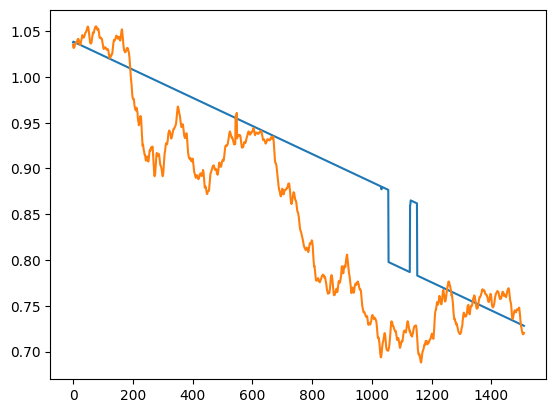

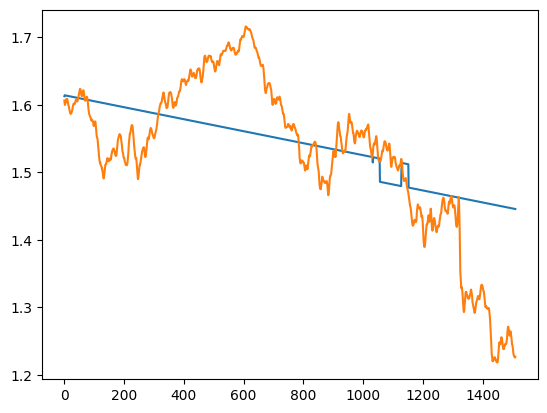

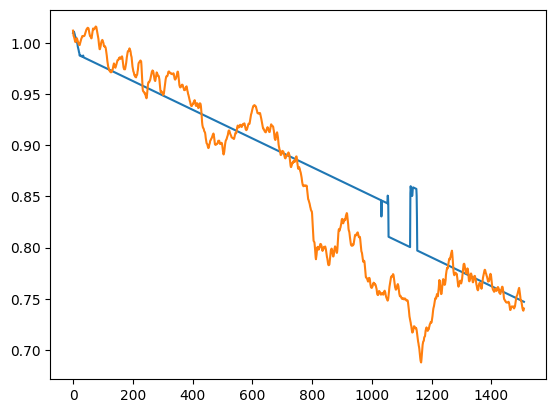

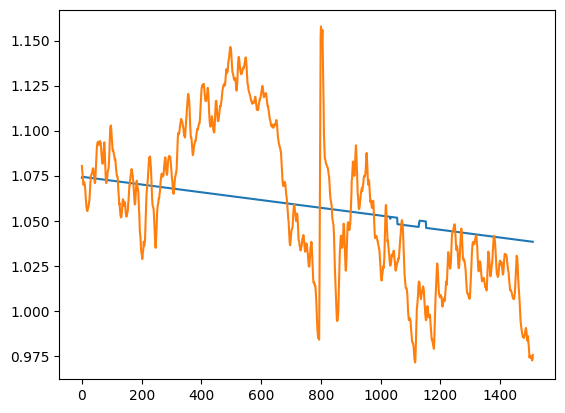

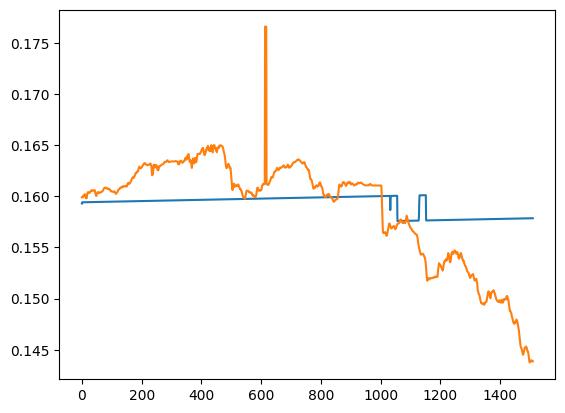

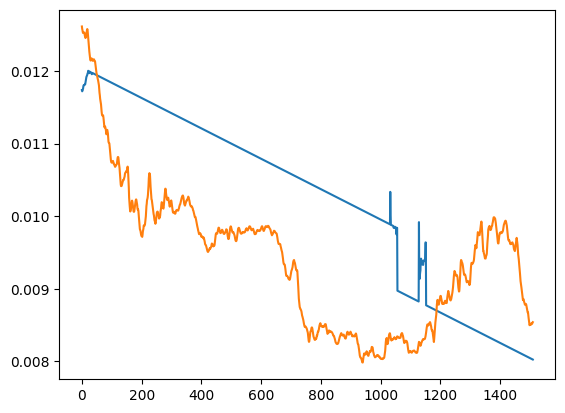

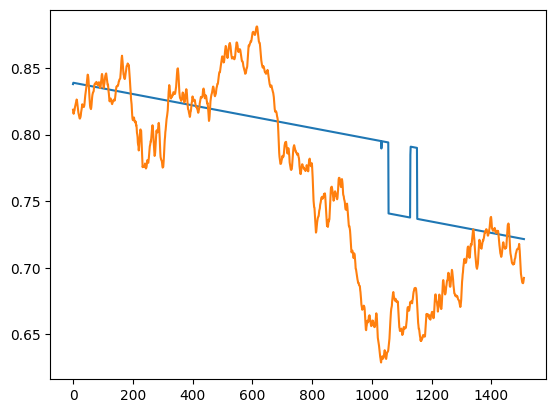

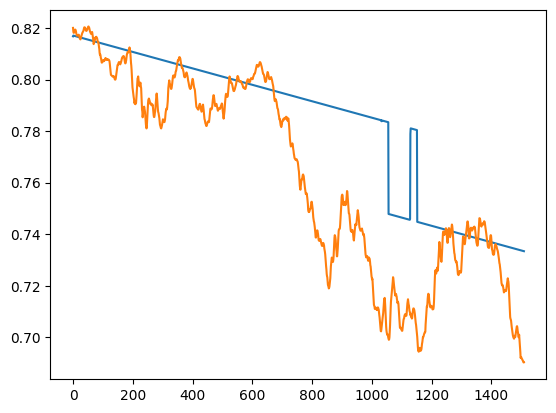

In [ ]:
for i in range(F.shape[1]):
    plt.figure()
    plt.plot(F[:,i])
    plt.plot(A[:,i])

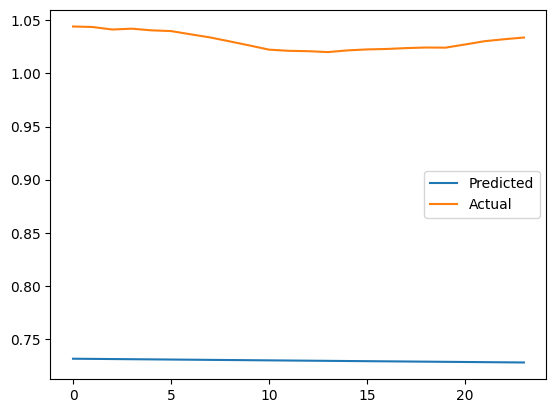

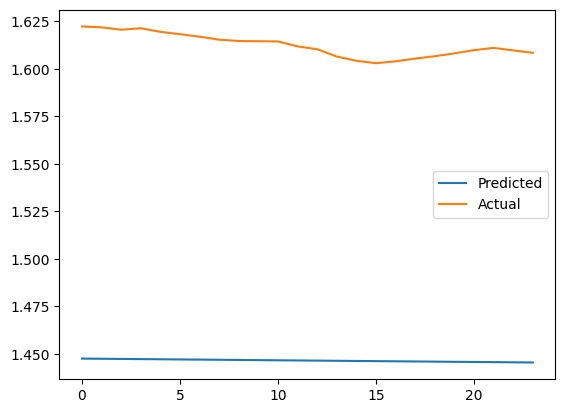

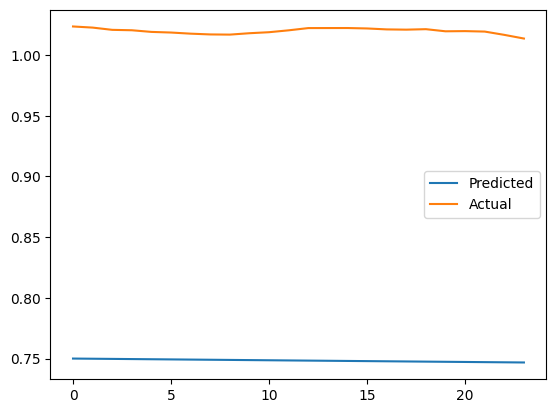

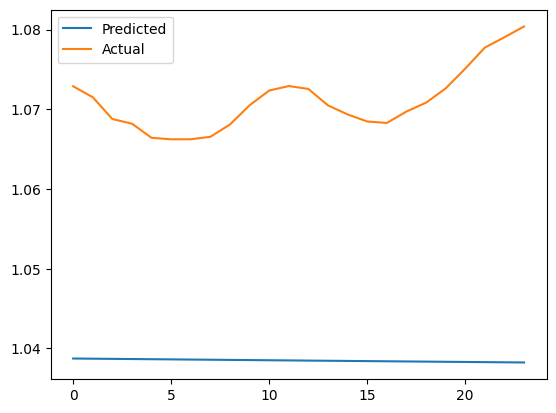

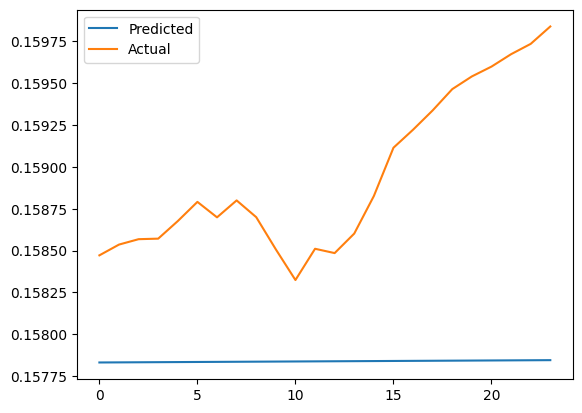

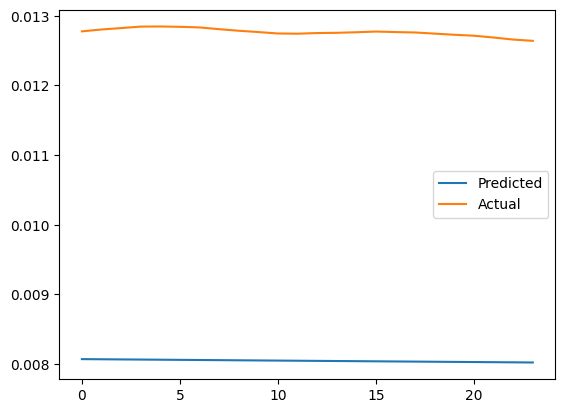

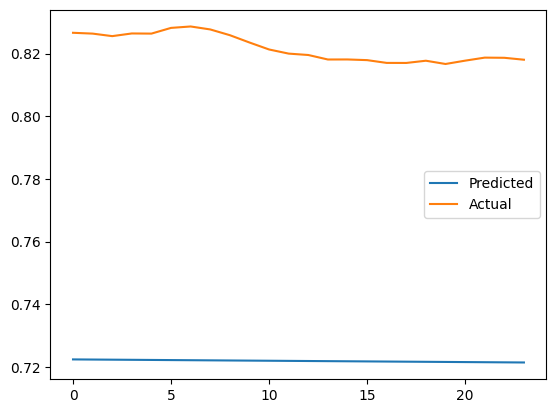

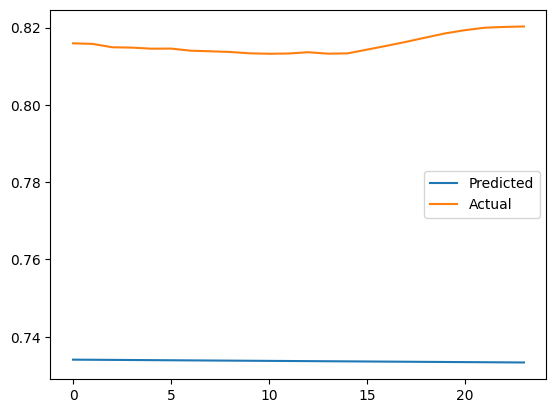

In [ ]:
for i in range(data_.shape[1]):
    plt.figure()
    plt.plot(b[:,i])
    plt.plot(data_[-24:,i])
    plt.legend(['Predicted','Actual'])

In [ ]:
in_sample.shape

(769, 8)

In [ ]:
complete_rules[:,1]

array([list([(25, 6), (1, 6)]), list([(26, 6), (1, 6)]),
       list([(27, 6), (1, 6)]), list([(28, 6), (1, 6)]),
       list([(29, 6), (1, 6)]), list([(30, 6), (1, 6)]),
       list([(35, 6), (1, 6)]), list([(37, 6), (1, 6)]),
       list([(38, 6), (1, 6)]), list([(44, 6), (1, 6)]),
       list([(98, 6), (1, 6)]), list([(115, 6), (1, 6)]),
       list([(155, 6), (1, 6)]), list([(166, 6), (1, 6)])], dtype=object)

In [ ]:
k = 0
i = 0

prems_activated = np.where(prem_terms[k,:] > min_activation)[0]
mask_mY = mY_[prems_activated,:,i]
max_index = np.argmax(mY_[prems_activated,:,i],axis=1)
index, count_index = np.unique(max_index, return_counts = True)
#print(count_index)
max_id = index[np.argmax(count_index)]

In [ ]:
mask_mY[:,2][np.where(max_index == 2)[0]].mean()

0.7433377721153108

In [ ]:
max_index[max_index==1].shape

(0,)

In [ ]:
a,b = np.unique(max_index, return_counts=True)

In [ ]:
blah = np.array([0, 0, 1, 1])
a, b = np.unique(blah, return_counts=True)
np.argmax(b)

0

In [ ]:
from utils import nmean_activation, check_if_inside, check_duplicate_rules, rearranje_rules, freq_activation, mean_activation
from tnorm import tnorm_product

In [ ]:
count_tnorm = np.vstack((mX_lagged_[:,2,16],mX_lagged_[:,0,16]))
tnorm_ = tnorm_product(count_tnorm)
a,b,c = mean_activation(tnorm_,0.5)
print(a)
print(b)
print(c)

False
0
0


In [ ]:
complete_rules[:,0].shape

(14,)

In [ ]:
np.unique(mX_lagged_)

array([0.00000000e+00, 9.99387662e-05, 3.85795202e-04, ...,
       9.99614205e-01, 9.99900061e-01, 1.00000000e+00])

In [ ]:
a,b,c = nmean_activation(mX_lagged_[:,3,70],0.5)
print(a)
print(b)
print(c)

False
0.46021989076656833
0.46021989076656833


In [ ]:
complete_rules

array([[list([(25, 6), (0, 6)]), list([(25, 6), (1, 6)]),
        list([(25, 6), (2, 6)]), list([(25, 6), (3, 4)]),
        list([(25, 6), (4, 6)]), list([(25, 6), (5, 3)]),
        list([(25, 6), (6, 6)]), list([(25, 6), (7, 6)])],
       [list([(26, 6), (0, 6)]), list([(26, 6), (1, 6)]),
        list([(26, 6), (2, 6)]), list([(26, 6), (3, 4)]),
        list([(26, 6), (4, 6)]), list([(26, 6), (5, 3)]),
        list([(26, 6), (6, 6)]), list([(26, 6), (7, 6)])],
       [list([(27, 6), (0, 6)]), list([(27, 6), (1, 6)]),
        list([(27, 6), (2, 6)]), list([(27, 6), (3, 4)]),
        list([(27, 6), (4, 6)]), list([(27, 6), (5, 3)]),
        list([(27, 6), (6, 6)]), list([(27, 6), (7, 6)])],
       [list([(28, 6), (0, 6)]), list([(28, 6), (1, 6)]),
        list([(28, 6), (2, 6)]), list([(28, 6), (3, 4)]),
        list([(28, 6), (4, 6)]), list([(28, 6), (5, 3)]),
        list([(28, 6), (6, 6)]), list([(28, 6), (7, 6)])],
       [list([(29, 6), (0, 6)]), list([(29, 6), (1, 6)]),
        li

In [ ]:
'''
init = 0
for i,a in enumerate(list_rules):
    try:
        ensemble_rules = a.complete_rules
        ensemble_prem_terms = a.prem_terms
        ensemble_antecedents = a.rules
        
        new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

        new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms,            ensemble_antecedents)

        wd_, _ = model.reweight_mf(mY_[init:init+ensemble_prem_terms.shape[1],:,:], new_rules, new_prem_terms)
        
        list_rules[i].complete_rules = new_rules
        list_rules[i].prem_terms = new_prem_terms
        list_rules[i].rules = new_antecedents
        list_rules[i].wd_ = wd_

        init += ensemble_prem_terms.shape[1]

    except Exception as e:
        print(e)
'''

'\ninit = 0\nfor i,a in enumerate(list_rules):\n    try:\n        ensemble_rules = a.complete_rules\n        ensemble_prem_terms = a.prem_terms\n        ensemble_antecedents = a.rules\n        \n        new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)\n\n        new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms,            ensemble_antecedents)\n\n        wd_, _ = model.reweight_mf(mY_[init:init+ensemble_prem_terms.shape[1],:,:], new_rules, new_prem_terms)\n        \n        list_rules[i].complete_rules = new_rules\n        list_rules[i].prem_terms = new_prem_terms\n        list_rules[i].rules = new_antecedents\n        list_rules[i].wd_ = wd_\n\n        init += ensemble_prem_terms.shape[1]\n\n    except Exception as e:\n        print(e)\n'

In [ ]:
initial_values = all_lagged[yp_lagged.shape[0]-1,:].reshape(1,-1)

test_values = test_data.values



In [ ]:
errors1

NameError: name 'errors1' is not defined

In [ ]:
#errors = predict_pattern(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_, lag = lag, mf_params_=mf_params_,num_series=num_series,h_prev=h_test,not_used_lag=not_used_lag,n_attempt=f'_predict_',wd_=wd_,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2], n_patterns=n_pattern, list_rules = list_rules)



In [ ]:
errors1

In [ ]:
#new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

#new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents)

#rw = Reweight(mY_,new_rules,new_prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)

#predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged,h_prev=h_prev,not_used_lag=not_used_lag,n_attempt='_{}'.format(i),wd_=wd_,ensemble_antecedents=new_antecedents,ensemble_rules=new_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])

In [ ]:
#rw = Reweight(mY_,complete_rules,prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)
#defuzz = Defuzzification(mf_params_,num_series)
#y_predict_ = defuzz.run('mom',agg_training,show=True)

In [ ]:
k = 2
t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24*k,24*(k+1))]
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
yp1 = deepcopy(yp[t_lagged,:])
yt1 = deepcopy(yt[t_lagged,:])
yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

data1 = deepcopy(data[t[len(t)-len(t_lagged):],:])
in_sample = data1[:data1.shape[0]-h_prev,:]
out_sample = data1[data1.shape[0]-h_prev:,:]

print(len(t_lagged))


In [ ]:
ll = [rule_object(None,None,None,k) for k in range(7)]

In [ ]:
wd_.shape

In [ ]:
complete_rules.shape

In [ ]:
list_rules[1].complete_rules

In [ ]:
all_lagged.shape

In [ ]:
all_yt[yp_lagged.shape[0] + t_val[0],:]

In [ ]:
out_sample[0,:]

In [ ]:
test_set = test_data.values

In [ ]:
plt.plot(np.arange(0,training_set.shape[0]),training_set[:,0],label='Train')
plt.plot(np.arange(training_set.shape[0],training_set.shape[0]+val_set.shape[0]),val_set[:,0],color='r',label='Validation')
plt.plot(np.arange(training_set.shape[0]+val_set.shape[0], training_set.shape[0]+val_set.shape[0] + test_set.shape[0]),test_set[:,0],label='Test')
plt.xlabel('Time')
plt.ylabel('Traffic rate')
plt.title('Data split')
plt.legend(['Train','Validation','Test'])

In [ ]:
a = dataset.corr()

In [ ]:
np.sort(a[0].values)[-5:]

In [ ]:
b = a[0].values

In [ ]:
for i in np.sort(a[0].values)[-5:]:
    print(np.where(np.isclose(b,i)))

In [ ]:
type(b)